In [22]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from datetime import timedelta
from pmdarima.arima import auto_arima
from sklearn.metrics import root_mean_squared_error
import pickle


In [23]:
df = pd.read_csv("../dataset.csv", index_col="ts", parse_dates = True)
df.head()

,id,light,temperature,soil_moisture,humidity,api_temp,precipitation,cloud_cover
ts,,,,,,,,
2025-04-01 21:15:00,1,34.3262,33.3125,3262.0,84,27.9,0.1,100
2025-04-01 21:30:00,2,33.9057,33.4688,3232.5,84,27.8,0.1,100
2025-04-01 21:45:00,3,33.2979,33.5938,3218.0,85,27.8,0.1,100
2025-04-01 22:00:00,4,33.6201,33.3281,3211.0,85,27.6,0.0,100
2025-04-01 22:15:00,5,33.2979,33.3438,3203.0,85,27.6,0.0,100


In [24]:
df = df.resample('D').mean()
df.head()

,id,light,temperature,soil_moisture,humidity,api_temp,precipitation,cloud_cover
ts,,,,,,,,
2025-04-01,6.0,30.485055,33.485800,3211.045455,83.909091,28.200000,0.027273,96.363636
2025-04-02,46.0,27.144790,33.753629,3158.710145,62.623188,31.623188,0.000000,87.246377
2025-04-03,128.5,25.908357,33.485352,3121.473958,76.322917,29.742708,0.025000,81.854167
2025-04-04,224.5,25.931506,33.122399,3223.473958,72.354167,30.153125,0.000000,36.416667
2025-04-05,320.0,141.128589,33.805593,3099.052632,71.084211,30.283158,0.000000,63.873684


In [ ]:
train_end = datetime(2025,4,9)
test_end = datetime(2025,4,11)

train_data = df[:train_end-timedelta(days=1)]
test_data = df[train_end:test_end]

# Training sarima to predict the temperature 

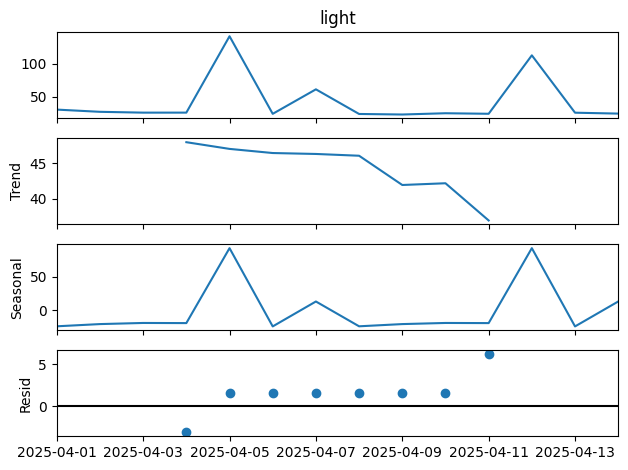

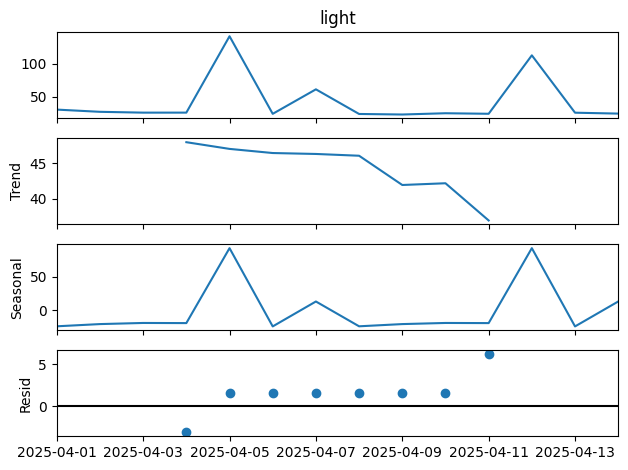

In [26]:
seasonal_decompose(df["light"], model="additive").plot()

## Find the D parameter

In [27]:
result = adfuller(df["light"].dropna(), autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: -4.282204949903383
p-value: 0.0004768096691112353
Critial Values:
   1%, -4.068853732362312
Critial Values:
   5%, -3.1271488757396453
Critial Values:
   10%, -2.7017297633136095


The ADF statistics value is less than 0.05, therefore, it is stationary.

## Find the P parameter

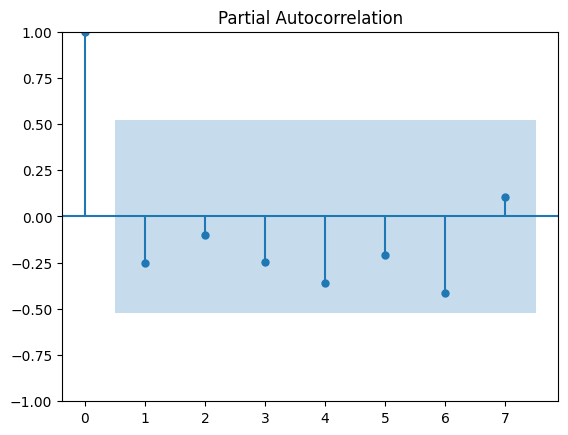

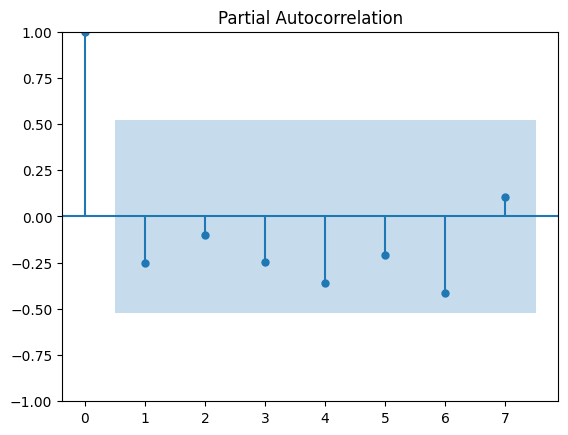

In [28]:
# I believe 2 or 3 is the variable for the term AR in order
plot_pacf(df["light"])

The two lags in the front are the most influential, therefore, p = 2

## Find the Q parameter

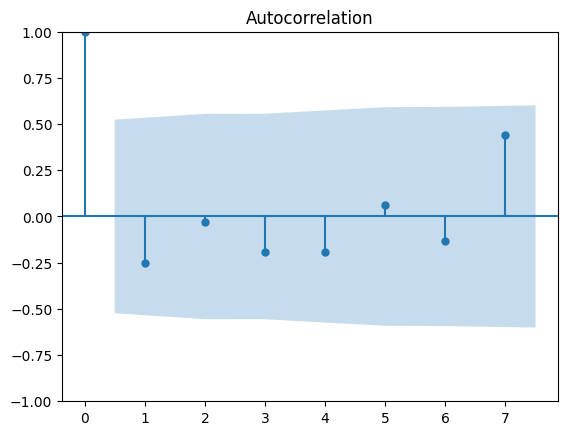

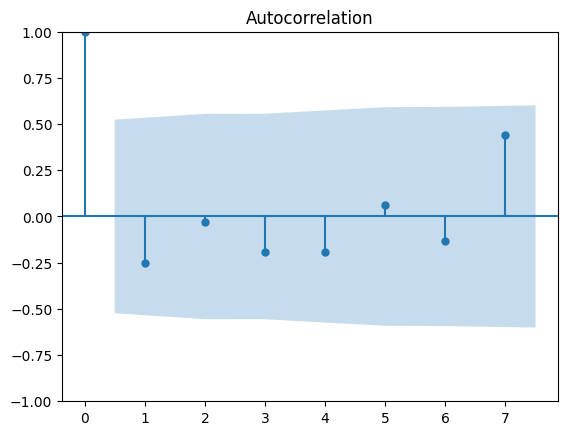

In [29]:
plot_acf(df["light"])

The graph is not clear, therefore, the q parameter might be 0 or 1

## Train the model

c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


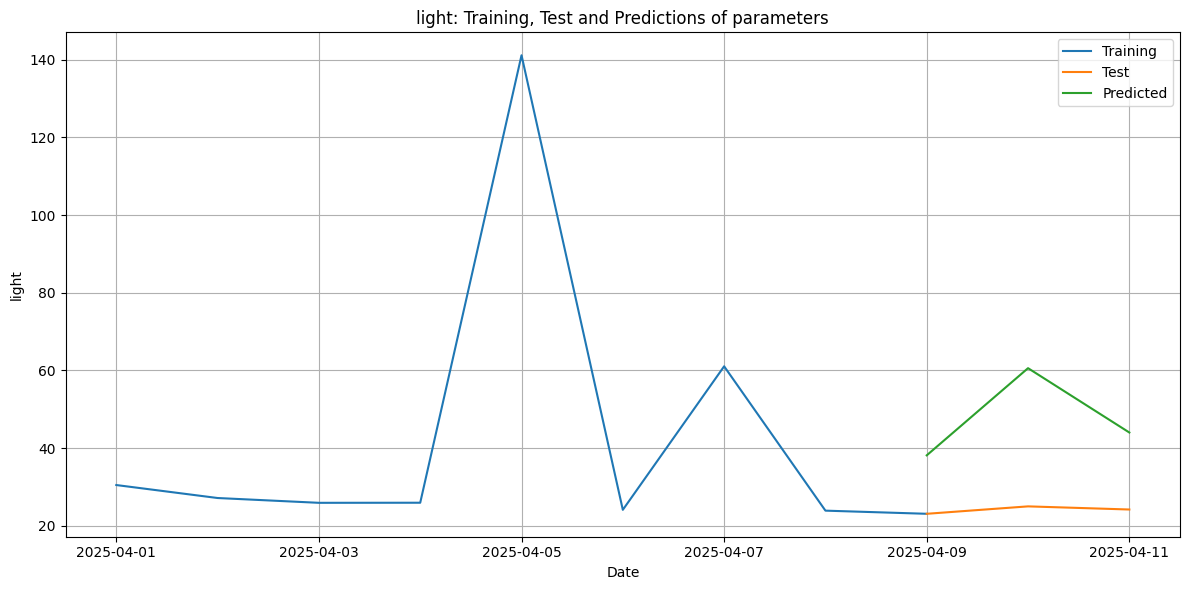

RMSE is :  25.067393579397336


In [30]:
model_temperature = SARIMAX(
    endog=train_data['light'],
    order=(1,0,1),
    seasonal_order=(1,0,1,3)
)
temperature_results = model_temperature.fit()


temperature_prediction = temperature_results.get_forecast(steps = int(test_data['light'].count())).predicted_mean
forecast_index = pd.date_range(
            start=test_data.index[0],
            freq=timedelta(days=1),
            periods=int(test_data['light'].count()),
        )
temperature_prediction.columns = ['predicted']

plt.figure(figsize=(12, 6))
# Ensure datetime index and proper plotting
plt.plot(train_data.index, train_data["light"], label="Training")
plt.plot(test_data.index, test_data["light"], label="Test")
plt.plot(test_data.index, temperature_prediction, label="Predicted")  # use the same x-axis as test

plt.legend()
plt.xlabel("Date")
plt.ylabel("light")
plt.title(f"light: Training, Test and Predictions of parameters")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"RMSE is : ", root_mean_squared_error(test_data['light'], temperature_prediction))

## Save the model using pickle

In [31]:
with open('../exports/light_sarima.pkl', 'wb') as file:
    pickle.dump(temperature_results, file)

# Training sarima to predict the precipitation 

In [54]:
help(seasonal_decompose)

Help on function seasonal_decompose in module statsmodels.tsa.seasonal:

seasonal_decompose(x, model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)
    Seasonal decomposition using moving averages.

    Parameters
    ----------
    x : array_like
        Time series. If 2d, individual series are in columns. x must contain 2
        complete cycles.
    model : {"additive", "multiplicative"}, optional
        Type of seasonal component. Abbreviations are accepted.
    filt : array_like, optional
        The filter coefficients for filtering out the seasonal component.
        The concrete moving average method used in filtering is determined by
        two_sided.
    period : int, optional
        Period of the series (e.g., 1 for annual, 4 for quarterly, etc). Must
        be used if x is not a pandas object or if the index of x does not have
        a frequency. Overrides default periodicity of x if x is a pandas
        object with a timeseries index.
    t

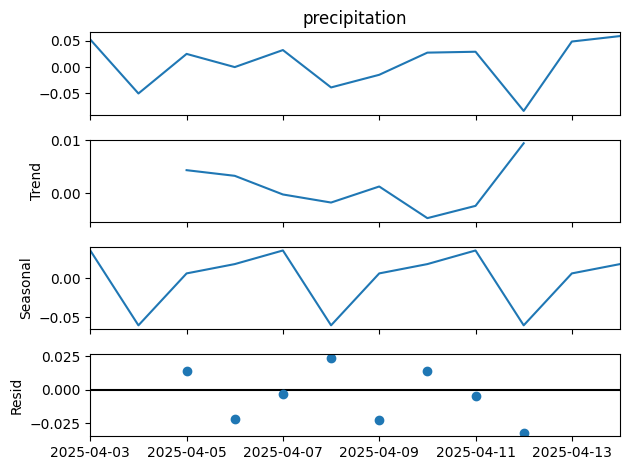

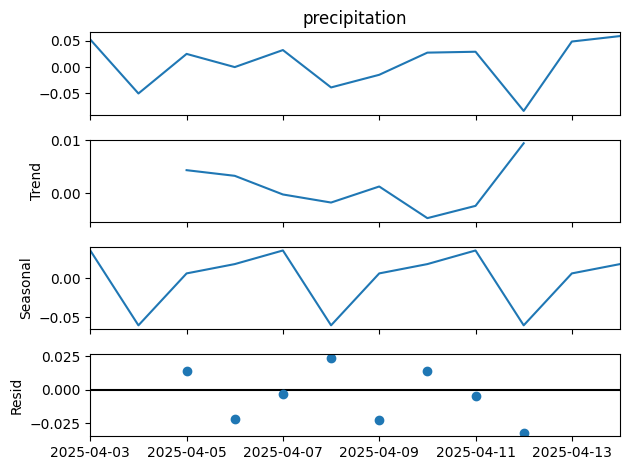

In [57]:
seasonal_decompose(df["precipitation"].diff().dropna().diff().dropna(), model="additive", period =4).plot()

## Find the D parameter

In [49]:
result = adfuller(df["precipitation"].diff().dropna().diff().dropna(), autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: -6.2637331603178295
p-value: 4.16264636489734e-08
Critial Values:
   1%, -4.473135048010974
Critial Values:
   5%, -3.28988060356653
Critial Values:
   10%, -2.7723823456790124


The model returns the p-value < 0.05, therefore, the d parameter must be 2.

## Find the P parameter

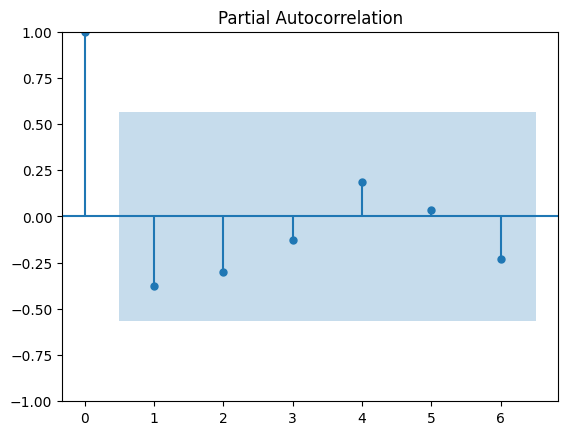

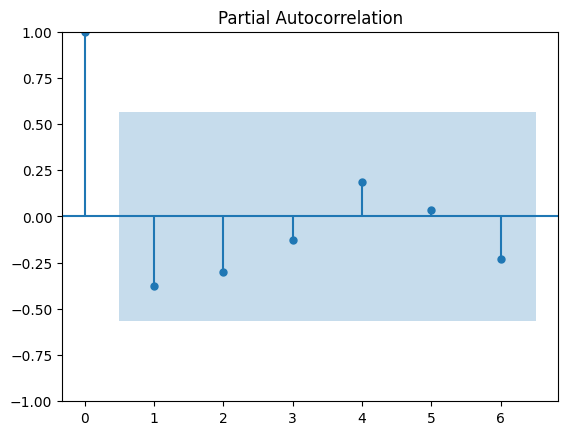

In [60]:
# I believe 2 or 3 is the variable for the term AR in order
plot_pacf(df["humidity"].diff().dropna().diff().dropna())


The 4 lags in the front are the most influential, therefore, p = 4

## Find the Q parameter

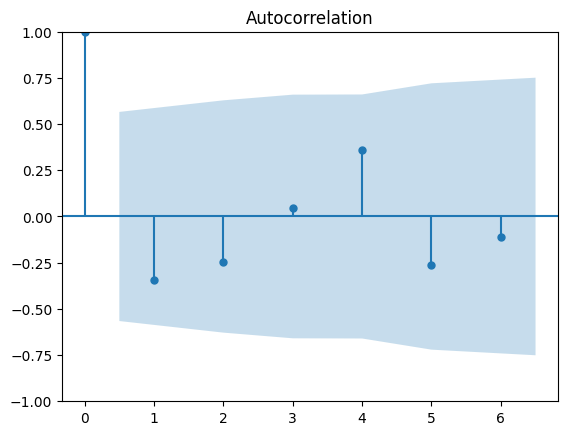

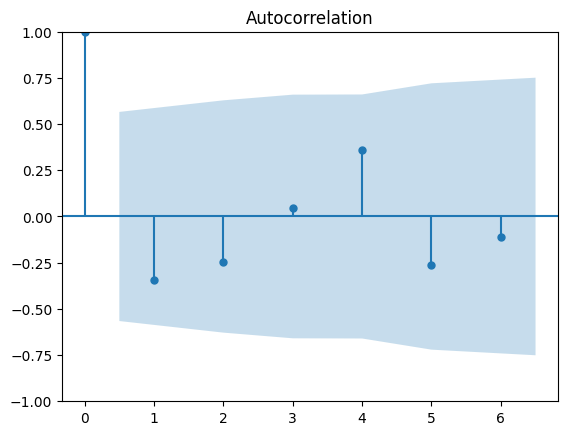

In [59]:
plot_acf(df["precipitation"].diff().dropna().diff().dropna())

The graph is not clear, therefore, the q parameter might be 0 or 1

## Train the model

c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


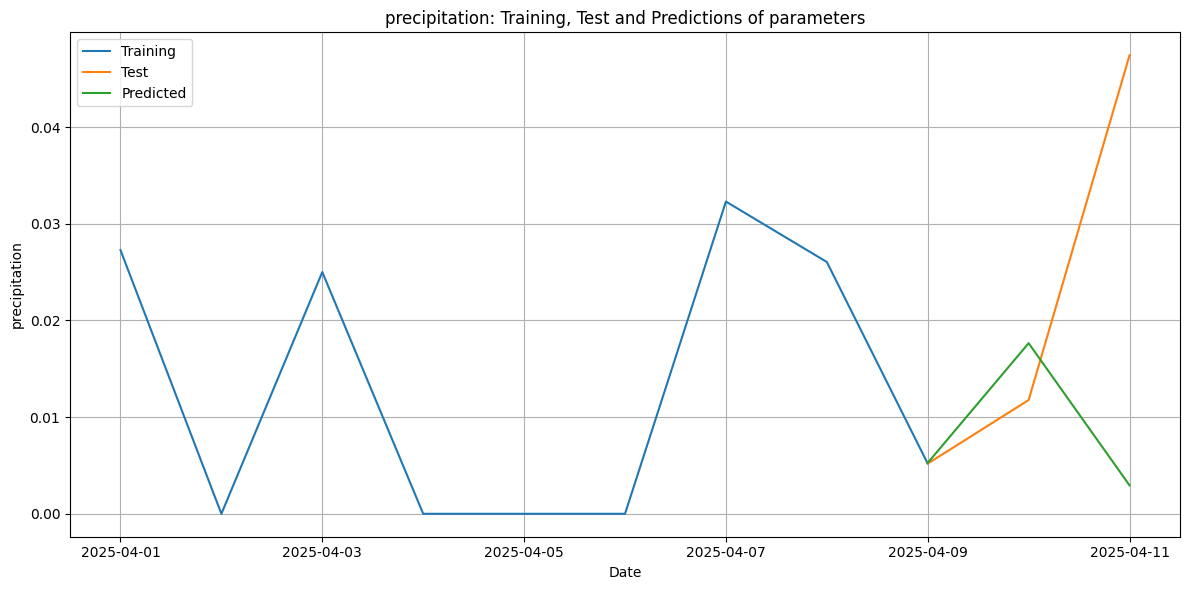

RMSE is :  0.025904731096452072


In [61]:
model_humidity = SARIMAX(
    endog=train_data['precipitation'],
    order=(1,2,1),
    seasonal_order=(1,2,1,4)
)
humidity_results = model_humidity.fit()

humidity_prediction = humidity_results.get_forecast(steps = int(test_data['precipitation'].count())).predicted_mean
forecast_index = pd.date_range(
            start=test_data.index[0],
            freq=timedelta(days=1),
            periods=int(test_data['precipitation'].count()),
        )
humidity_prediction.columns = ['predicted']

plt.figure(figsize=(12, 6))
# Ensure datetime index and proper plotting
plt.plot(train_data.index, train_data["precipitation"], label="Training")
plt.plot(test_data.index, test_data["precipitation"], label="Test")
plt.plot(test_data.index, humidity_prediction, label="Predicted")  # use the same x-axis as test

plt.legend()
plt.xlabel("Date")
plt.ylabel("precipitation")
plt.title(f"precipitation: Training, Test and Predictions of parameters")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"RMSE is : ", root_mean_squared_error(test_data['precipitation'], humidity_prediction))

## Save the model using pickle

In [62]:
with open('../exports/precipitation_sarima.pkl', 'wb') as file:
    pickle.dump(humidity_results, file)

# Training sarima to predict the temperature 

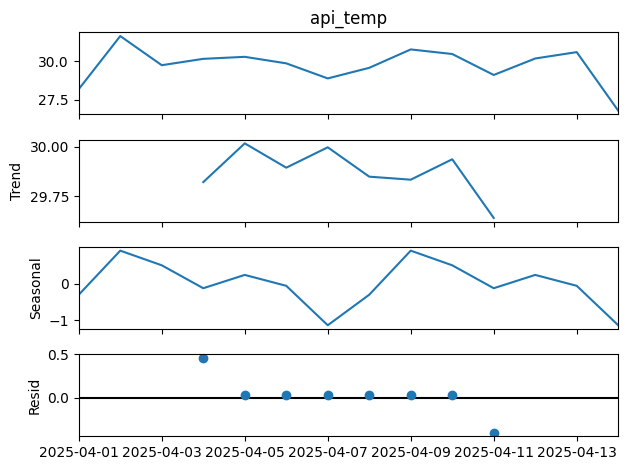

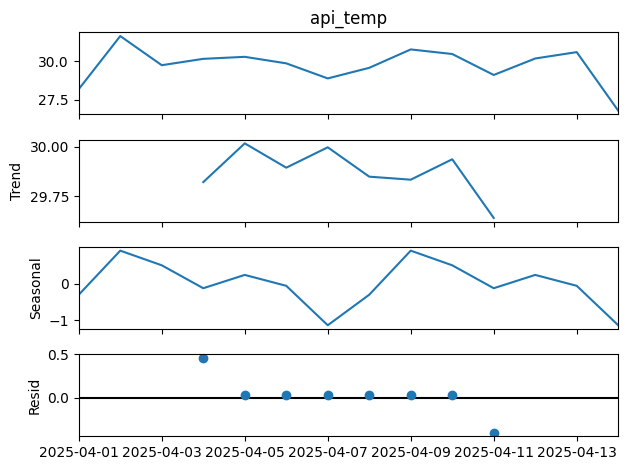

In [38]:
seasonal_decompose(df["api_temp"], model="additive").plot()

## Find the D parameter

In [39]:
result = adfuller(df["api_temp"].dropna(), autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: -1.6046739772129046
p-value: 0.4812451879666485
Critial Values:
   1%, -4.473135048010974
Critial Values:
   5%, -3.28988060356653
Critial Values:
   10%, -2.7723823456790124


The ADF statistics value is less than 0.05, therefore, it is stationary.

## Find the P parameter

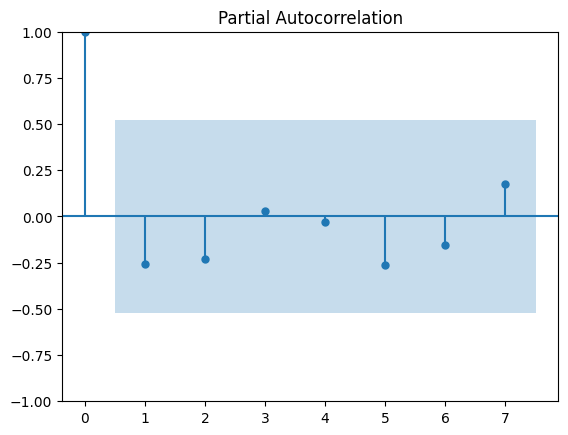

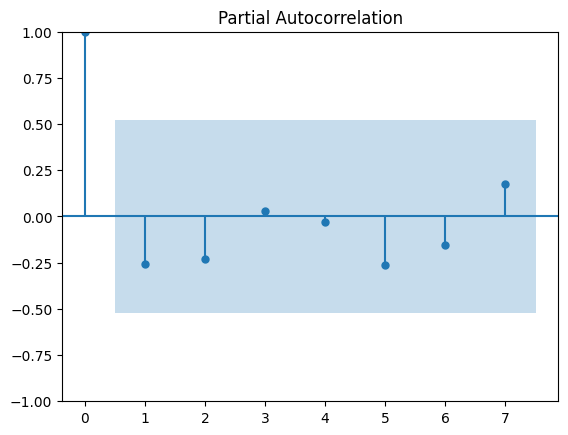

In [40]:
# I believe 2 or 3 is the variable for the term AR in order
plot_pacf(df["api_temp"])

The three lags in the front are the most influential, therefore, p = 3

## Find the Q parameter

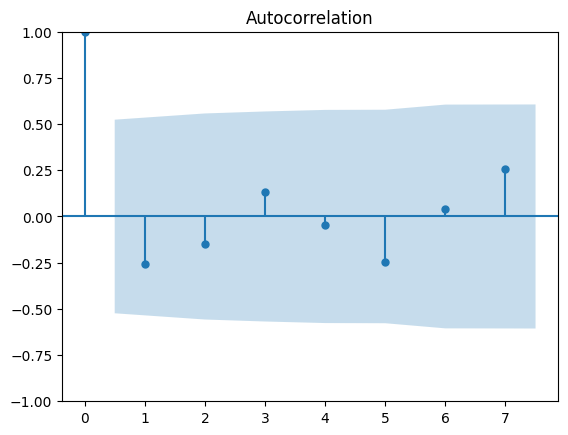

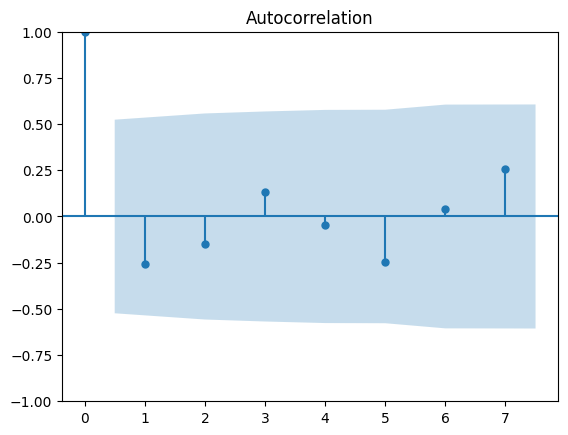

In [41]:
plot_acf(df["api_temp"])

The graph is not clear, therefore, the q parameter might be 0 or 1

## Train the model

c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


2025-04-10    29.483556
2025-04-11    30.195454
2025-04-12    30.008515
Freq: D, Name: predicted_mean, dtype: float64


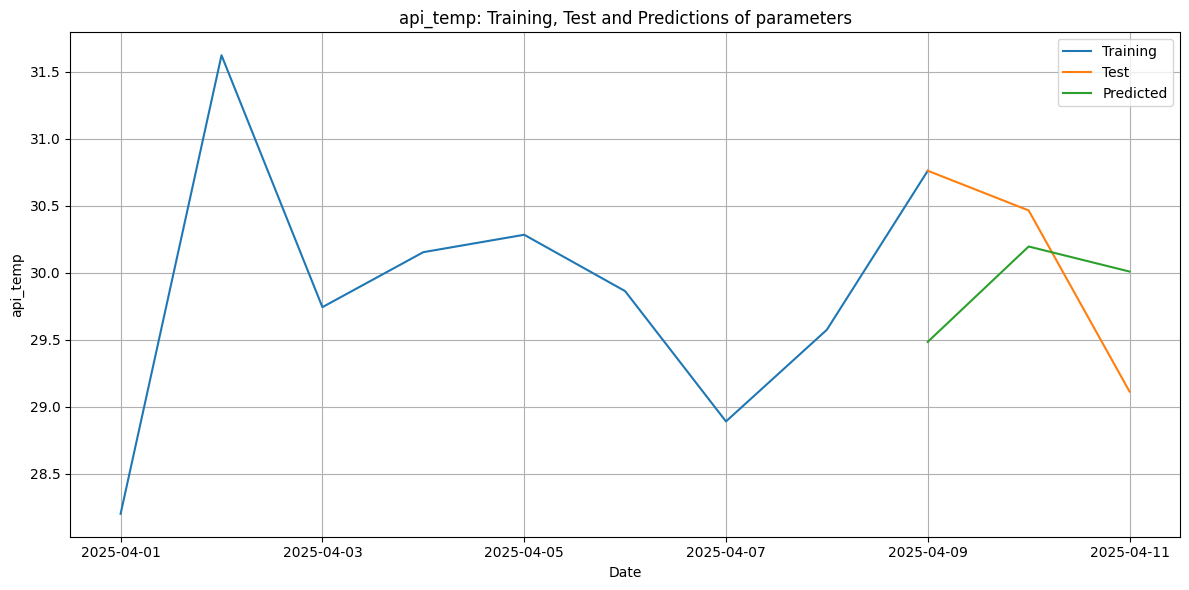

RMSE is :  0.9142454585400088


In [42]:
model_api_temp = SARIMAX(
    endog=train_data['api_temp'],
    order=(1,0,1),
    seasonal_order=(1,0,1,3)
)
api_temp_results = model_api_temp.fit()

api_temp_prediction = api_temp_results.get_forecast(steps = int(test_data['api_temp'].count())).predicted_mean
forecast_index = pd.date_range(
            start=test_data.index[0],
            freq=timedelta(days=1),
            periods=int(test_data['api_temp'].count()),
        )
api_temp_prediction.columns = ['predicted']

print(api_temp_prediction)

plt.figure(figsize=(12, 6))
# Ensure datetime index and proper plotting
plt.plot(train_data.index, train_data["api_temp"], label="Training")
plt.plot(test_data.index, test_data["api_temp"], label="Test")
plt.plot(test_data.index, api_temp_prediction, label="Predicted")  # use the same x-axis as test

plt.legend()
plt.xlabel("Date")
plt.ylabel("api_temp")
plt.title(f"api_temp: Training, Test and Predictions of parameters")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"RMSE is : ", root_mean_squared_error(test_data['api_temp'], api_temp_prediction))

## Save the model using pickle

In [43]:
with open('../exports/api_temp_sarima.pkl', 'wb') as file:
    pickle.dump(api_temp_results, file)